# Описание проекта

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года.

# Разделим наш проект на части.

* [Получение общей информации из исходного файла.](#id-section1)

* [Предобработка данных.](#id-section2)

* [Исследовательский анализ. Ответы на поставленные вопросы.](#id-section3)

* [Портрет пользователя каждого региона.](#id-section4)

* [Формулирование и проверка гипотез.](#id-section5)

* [Общий вывод.](#id-section6)

In [533]:
import pandas as pd
import math as mt
import numpy as np
from scipy import stats as st
import seaborn as sns
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')

<div id='id-section1'/>

# Шаг 1. Получение общей информации из исходного файла.

In [534]:
df = pd.read_csv('/datasets/games.csv')

In [535]:
df.sample(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
3298,Half-Life 2,XB,2005.0,Shooter,0.37,0.21,0.00,0.03,90.0,8.6,M
1400,Ryse: Son of Rome,XOne,2013.0,Action,0.83,0.43,0.00,0.13,60.0,6.1,M
5788,SD Gundam G Generation: Overworld,PSP,2012.0,Strategy,0.00,0.00,0.31,0.00,NaN,NaN,NaN
2773,WarioWare: Twisted!,GBA,NaN,Puzzle,0.16,0.06,0.50,0.02,NaN,NaN,NaN
5925,1701 A.D.,PC,2006.0,Simulation,0.00,0.25,0.00,0.04,79.0,8.3,E10+
14916,CID The Dummy,Wii,2009.0,Platform,0.02,0.00,0.00,0.00,31.0,tbd,E10+
10334,NASCAR '14,PS3,2014.0,Racing,0.09,0.00,0.00,0.02,67.0,4.6,E
5468,Ninja Blade,X360,2009.0,Action,0.14,0.14,0.02,0.03,68.0,6.8,M
7150,Skies of Arcadia Legends,GC,2002.0,Role-Playing,0.17,0.04,0.00,0.01,84.0,9.2,T
4760,Naughty Bear,X360,2010.0,Action,0.21,0.15,0.00,0.04,43.0,5.6,T


In [536]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


## Вывод:

На входе имеем таблицу *games*:
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными

<div id='id-section2'/>

# Шаг 2. Предобработка данных

Приведём все названия столбцов к нижнему регистру.

In [537]:
df.rename(columns=lambda x: x.lower(), inplace=True)

Удалим пропущенные значения в столбцах *name* и *year_of_release* т.к. их количество мало, а данные важны.

In [538]:
df = df.dropna(subset=['name', 'year_of_release'])

In [539]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         9839 non-null object
rating             9768 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Обратим внимание на значние tbd в столбце *User_Score*, скорее всего означающее to be determed, т.е. на данный момент значение не определено. Заменим его на Nan, для корректной дальнейшей работы с таблицей.

In [540]:
df['user_score'] = df['user_score'].where(df['user_score'] != 'tbd', np.nan)
df['user_score'] = df[df['user_score'].notna()]['user_score'].astype('float64')
df['year_of_release'] = df['year_of_release'].astype('int64')

In [541]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             9768 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [542]:
df.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
count,16444.000000,16444.000000,16444.000000,16444.000000,16444.000000,7983.000000,7463.000000
mean,2006.486256,0.264012,0.145930,0.078487,0.047594,68.994363,7.126330
std,5.875525,0.818378,0.506716,0.311100,0.188005,13.920060,1.499447
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,7.500000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000


Также обратим внимание на большое количество нулевых продаж по странам, особенно в Японии *JP_sales*. Предполагаем, что это означает, что количество продажи были, но менее 0.01 млн.

In [543]:
df.duplicated().sum()

0

Дупликатов не наблюдается

Добавим в таблицу сумму всех продаж для каждой игры

In [544]:
df['sum_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [545]:
df[df['year_of_release']==2015]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98
99,Call of Duty: Black Ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,NaN,7.39
105,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M,7.17
...,...,...,...,...,...,...,...,...,...,...,...,...
16597,Saints Row: Gat out of Hell,XOne,2015,Action,0.00,0.01,0.00,0.00,65.0,6.0,M,0.01
16608,Mario & Luigi: Paper Jam & Mario Kart 7 Double...,3DS,2015,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16610,Kiniro no Corda 3,3DS,2015,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16618,Xblaze: Lost Memories,PSV,2015,Adventure,0.01,0.00,0.00,0.00,NaN,7.0,M,0.01


## Вывод:

Преобразовали названия столбцов к нижнему регистру.
Преобразовали столбец *year_of_release* к формату int64, столбец *user_score* к формату float64. Значения tbd в столбце приняли как пропущенные, заменили на Nan. Пропущенные значения в столбцах с рейтингами не будем удалять или заменять чтобы не искажать данные т.к. пропущенных значений более половины.
Добавили в таблицу суммарные продажи по всем регионам.

<div id='id-section3'/>

# Шаг 3. Исследовательский анализ. Ответы на поставленные вопросы.

#### Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

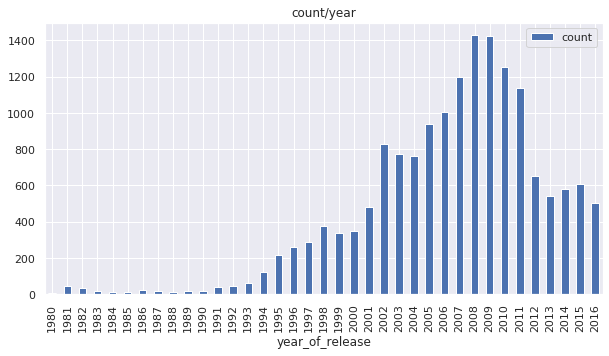

In [546]:
grouped_year = df.pivot_table(index='year_of_release', values='name', aggfunc={'count'})
grouped_year.plot(kind='bar', figsize=(10, 5), title='count/year')

Видим, что данные до 1995 года не так важны. После 1996 года идёт резкий рост выпускаемых игр вплоть до 2008-2009 года, затем выпуск идёт на спад.

#### Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

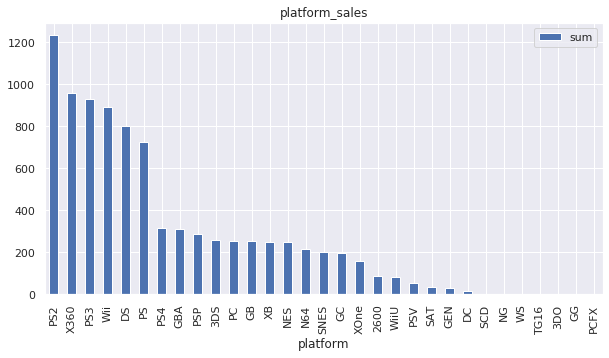

In [547]:
grouped_platform = df.pivot_table(index='platform', values='sum_sales', aggfunc={'sum'}).sort_values('sum', ascending=False)
grouped_platform.plot(kind='bar', figsize=(10, 5), title='platform_sales')

В качестве платформ с наибольшими продажами выберем первые 6

In [548]:
top_platform = grouped_platform.head(6)
top_platform

,sum
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58


In [549]:
def plot_sns(list, data):
    for i in range(len(list)):
        ax = sns.distplot(data[data['platform']==list[i]]['year_of_release'].dropna(), hist=False, label=list[i])
        sns.set(rc={'figure.figsize':(10, 5)})
        ax.set_title('top_platforms_living')
        ax.set_ylabel('density')

In [550]:
def plot_top(list, data):
    for i in range(len(list)):
        grouped = (data[data['platform']==list[i]]
              .pivot_table(index='year_of_release', values='sum_sales', aggfunc={'sum'})
              .sort_values('year_of_release', ascending=True))
        ax = grouped.plot(kind='bar', title=list[i])
        ax.set_ylabel('sales')
        plt.show()

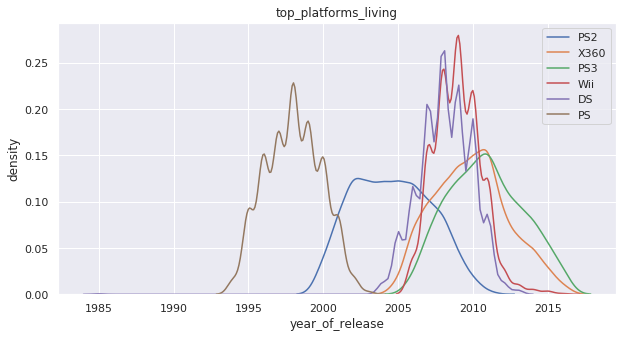

In [551]:
plot_sns(top_platform.index, df)

Отметим, что в как правило продолжительность существования платформы около 9 лет. Новая платформа появляется(приближается к пиковым продажам) в срок до 3 лет, исчезает(приближается к нулевым подажам) в течении 3-4 лет.

#### Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

На основе построенных графиков видим, что начиная с 1995 года начинается резкий рост выпуска новых игр для различных платформ.
Далее отметим 2 скачка: в 2002 и 2005 и резкое падение в 2009г., продолжающееся до 2012 года, далее ситуациия стала более стабильной. На основе графиков, показывающих распределние выпуска игр по годам на самых популярных платформах можем сделать вывод, что за актуальный период можем взять период с 2012 года по 2016, а период ранее в дальнейшем не учитывать.


#### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

Text(0, 0.5, 'sales')

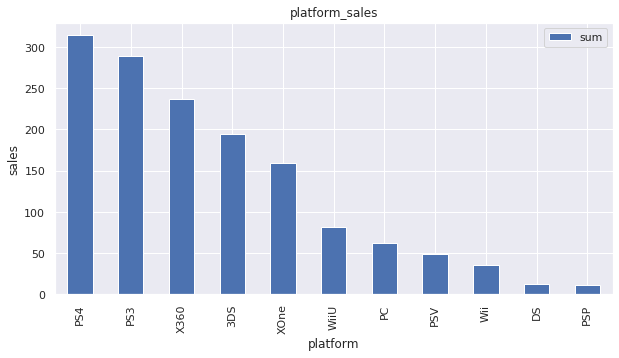

In [552]:
df_current = df[df['year_of_release'] >= 2012]
grouped_current = (df_current
                   .pivot_table(index='platform', values='sum_sales', aggfunc={'sum'})
                   .sort_values('sum', ascending=False))
ax = grouped_current.plot(kind='bar',figsize=(10, 5), title='platform_sales')
ax.set_ylabel('sales')

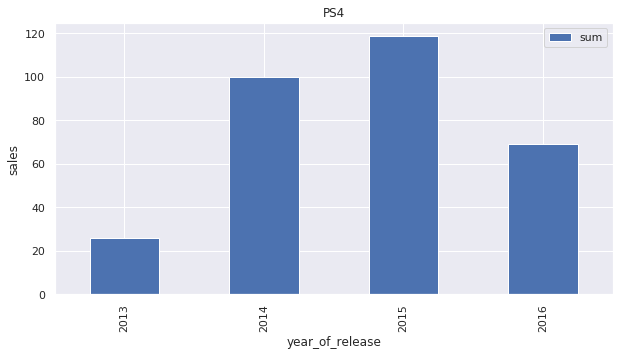

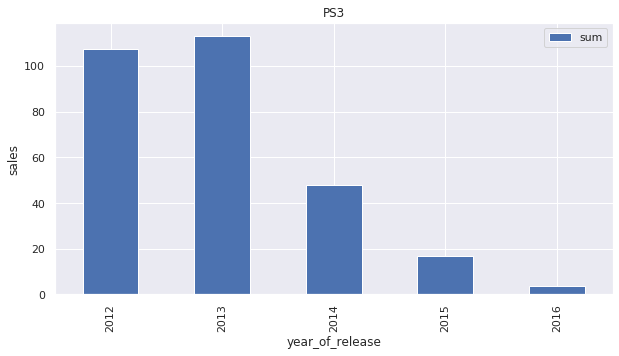

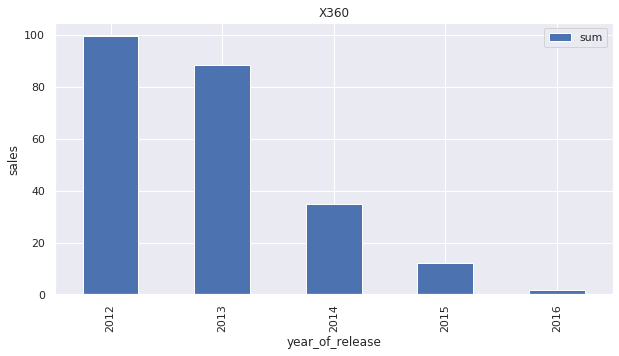

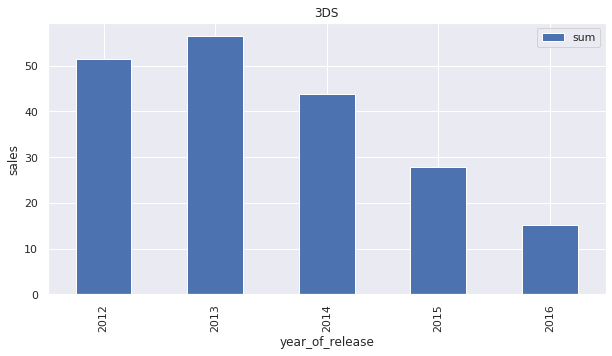

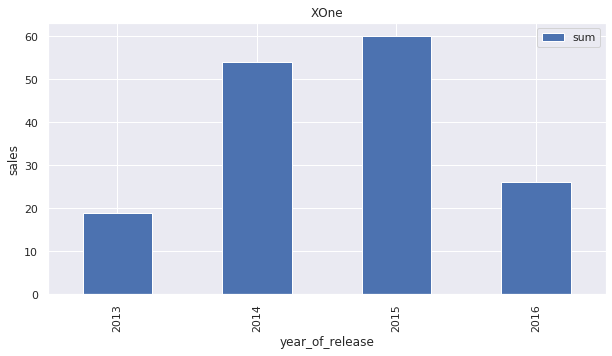

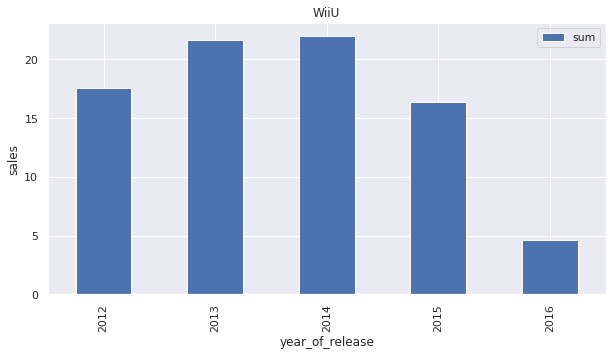

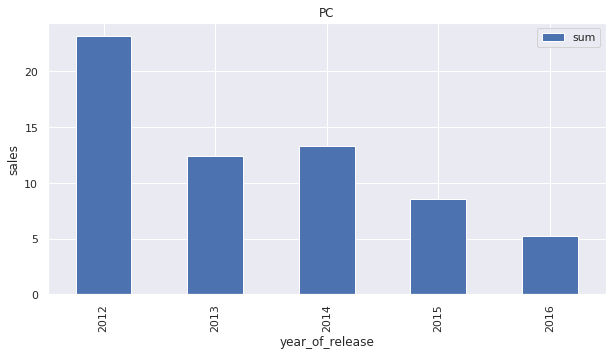

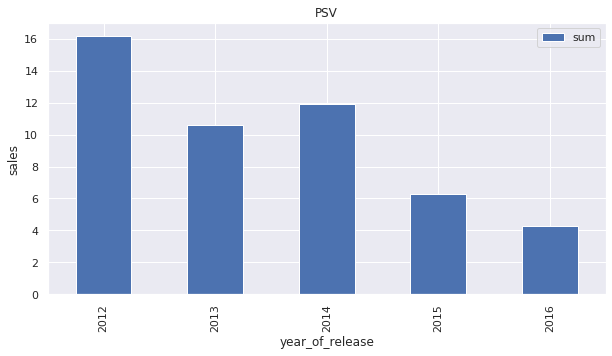

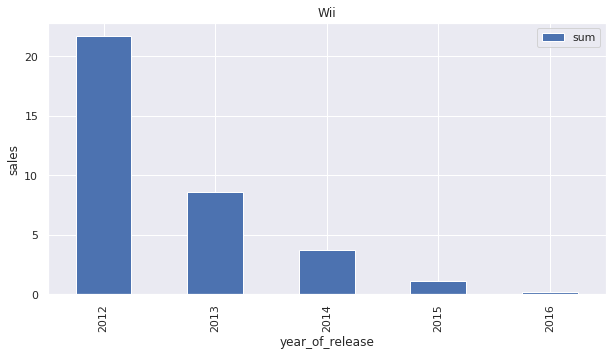

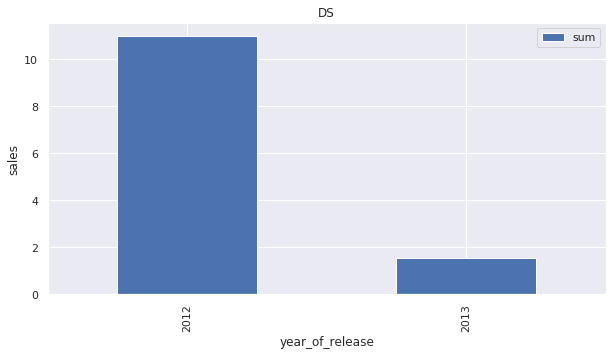

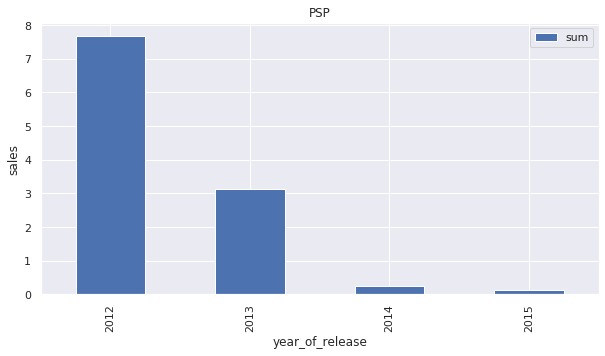

In [553]:
grouped_current = grouped_current.reset_index()
plot_top(grouped_current['platform'], df_current)

Видим, что по общим продажам лидируют PS4, PS3 и X360, но к 2016 год продажи PS3 и X360 постепенно падают, т.к. жизненный цикл подходит к концу.
Отметим PS4 и XOne, на 2016 год это свежие и потенциально прибильные платформы, их продажи растут.

#### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

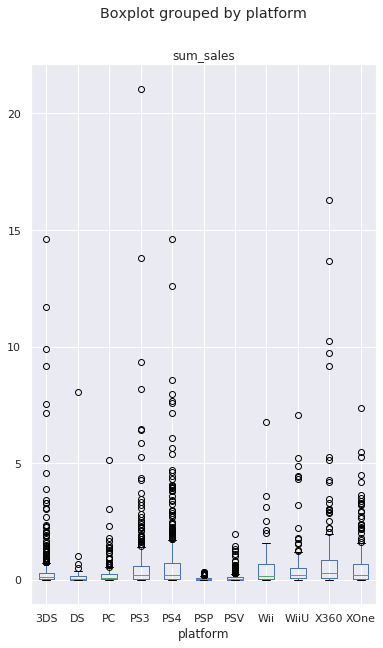

In [554]:
df_current.boxplot('sum_sales', figsize=(6, 10), by='platform')

Сравнивая потенциально прибыльные PS4 и XOne, выпущенные в один год, видим, что на PS4 игры продаются лучше. У платформы PSP очень малый диапазон разброса значений.
Отметим преодоление отметки в 20 млн продаж для PS3 не смотря на то, что с 2012 года ее жизненный цикл подходит к концу.

#### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы

Рассмотрим платформу X360

In [555]:
list = ['na_sales', 'jp_sales', 'eu_sales', 'other_sales', 'sum_sales', 'critic_score', 'user_score']
df_x360 = df_current[df_current['platform']=='X360'][list]
df_x360.corr()[['critic_score', 'user_score']]

,critic_score,user_score
na_sales,0.342341,-0.000710
jp_sales,0.233093,0.095023
eu_sales,0.354643,0.017297
other_sales,0.362118,0.001865
sum_sales,0.360573,0.006164
critic_score,1.000000,0.557352
user_score,0.557352,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a5024b610>,
      dtype=object)

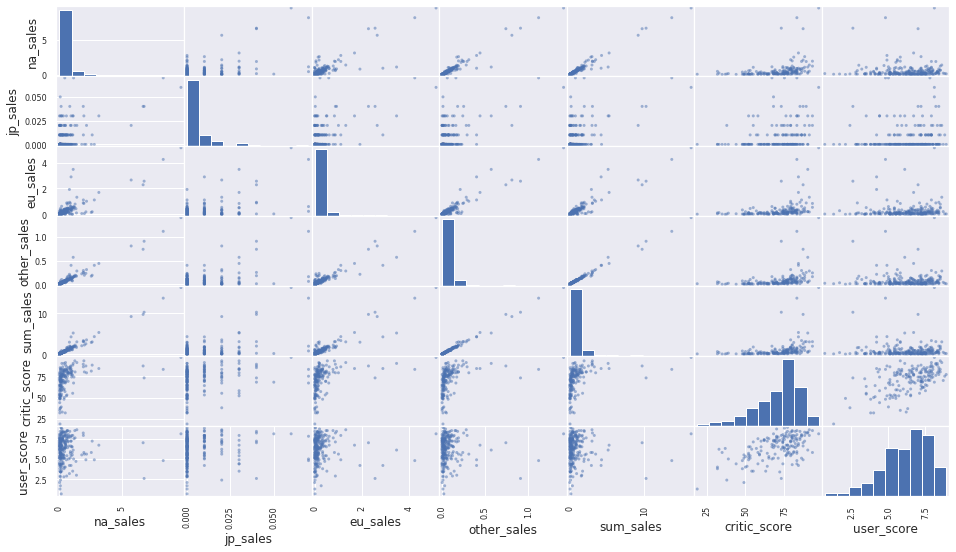

In [556]:
pd.plotting.scatter_matrix(df_x360, figsize=(16, 9))

Видим, что продажи сильнее зависят от оценки критиков, чем пользователей, зависимость от оценки пользователей очень слабая. Отметим, что продажи в Японии меньше всего зависят от оценок критиков.

По построенной диаграмме рассеяния видим, что разброс продаж начинается после оценки в 75 баллов от критиков.

<div class="alert alert-block alert-success">
<b>Комментарии от ревьюера:</b>

В таком масштабе конечно не совсем информативно, но рассчет корреляции проведен верно.
</div>

#### Соотнесите выводы с продажами игр на других платформах.

In [557]:
df_scores = df_current[list]
df_scores.corr()[['critic_score', 'user_score']]

,critic_score,user_score
na_sales,0.290240,-0.014217
jp_sales,0.116596,0.163980
eu_sales,0.283254,-0.022042
other_sales,0.272509,-0.010909
sum_sales,0.308197,0.004429
critic_score,1.000000,0.517727
user_score,0.517727,1.000000


Делая вывод по всем платформам, можем сказать, что рейтинги пользователей практически никак не влияют на продажи. Зависимость от оценок критиков слабая.

#### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Построим график, показывающий сумму продаж по всем жанрам

Text(0, 0.5, 'sales')

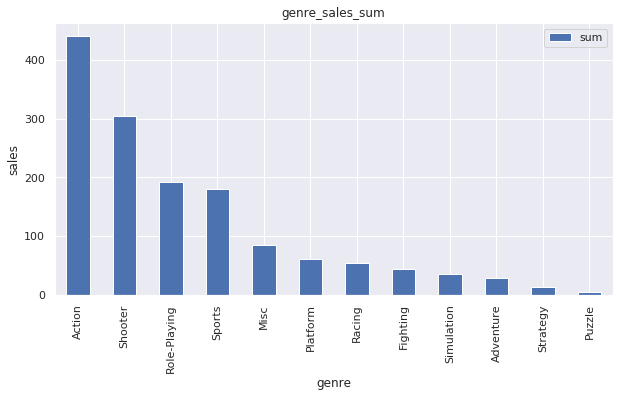

In [558]:
grouped_genre = df_current.pivot_table(index='genre', values='sum_sales', aggfunc={'sum'}).sort_values('sum', ascending=False)
ax = grouped_genre.plot(kind='bar', figsize=(10, 5), title='genre_sales_sum')
ax.set_ylabel('sales')

Самый продаваемый жанр - action, на втором месте shooter, хуже всего продается - puzzle

Посмторим на прибыльность каждой игры в жанре

Text(0, 0.5, 'sales')

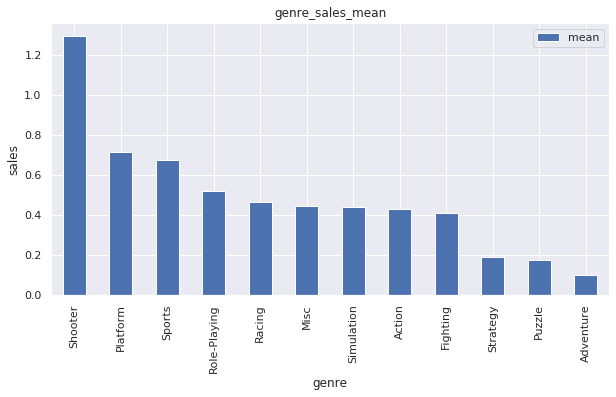

In [559]:
grouped_genre = df_current.pivot_table(index='genre', values='sum_sales', aggfunc={'mean'}).sort_values('mean', ascending=False)
ax = grouped_genre.plot(kind='bar',figsize=(10, 5), title='genre_sales_mean')
ax.set_ylabel('sales')

Однако видим, что в среднем больше покупают - shooter, затем идёт platform, который находится лишь на 6 месте по количеству проданых игр. Абсолютный лидер по количеству выпускаемых игр - жанр action находится лишь на 8 месте по прибыльности.
Самые низкоприбыльные жанры(Puzzle, Strategy, Adventure) являются также самыми низковыпускаемыми.
Это говорит о том, что рынок переполнен жанром Action и потенциаьно более прибыльный жанр - Shooter.

## Вывод:

Начиная с 1995 года начинается резкий рост выпуска новых игр для различных платформ.
Далее отметим 2 скачка: в 2002 и 2005 и резкое падение 2009г. до 2012г, далее ситуация более стабильная. На основе графиков, показывающих распределние выпуска игр по годам на самых популярных платформах можем сделать вывод, что за актуальный период можем взять период с 2012 года по 2016. Период появления и исчезновения платформы - 3-4 года.

Видим, что по общим продажам лидируют PS4, PS3 и X360, но к 2016 году продажи PS3 и X360 постепенно падают, т.к. жизненный цикл подходит к концу.
Отметим PS4 и XOne, на 2016 год это свежие и потенциально прибильные платформы, продажи которых растут, причем PS4 уже лидирует по продажам. 

Сравнивая потенциально прибыльные PS4 и XOne, выпущенные в один год, видим, что на PS4 игры продаются лучше. У платформы PSP очень малый диапазон разброса значений.
Отметим преодоление отметки в 20 млн продаж для PS3 не смотря на то, что с 2012 года ее жизненный цикл подходит к концу.

Делая вывод по всем платформам, можем сказать, что рейтинги пользователей практически никак не влияют на продажи. Зависимость от оценок критиков слабая.

По построенной диаграмме рассеяния видим, что разброс продаж начинается после оценки в 75 баллов от критиков.

<div id='id-section4'/>

# Шаг 4. Портрет пользователя каждого региона.

#### Самые популярные платформы (топ-5). Опишите различия в долях продаж.

In [560]:
df_current

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


In [561]:
list = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
for i in range(len(list)):    
    ax = (df_current
     .pivot_table(index='platform', values=list[i], aggfunc={'sum'})
     .sort_values('sum', ascending=False)
     .head())
    ax['per'] = (ax['sum'] / ax['sum'].sum())*100
    print(list[i])
    display(ax)
    print()

na_sales


,sum,per
platform,,
X360,140.05,27.976428
PS4,108.74,21.721934
PS3,103.38,20.651219
XOne,93.12,18.601678
3DS,55.31,11.048742



eu_sales


,sum,per
platform,,
PS4,141.09,33.858891
PS3,106.86,25.644348
X360,74.52,17.883369
XOne,51.59,12.380610
3DS,42.64,10.232781



jp_sales


,sum,per
platform,,
3DS,87.79,50.719279
PS3,35.29,20.388237
PSV,21.04,12.155526
PS4,15.96,9.220637
WiiU,13.01,7.516321



other_sales


,sum,per
platform,,
PS4,48.35,35.775065
PS3,43.26,32.008879
X360,20.40,15.094340
XOne,14.27,10.558639
3DS,8.87,6.563078


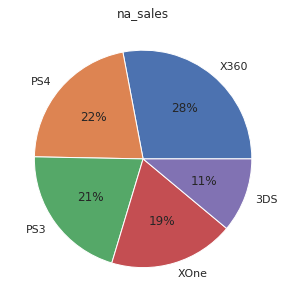

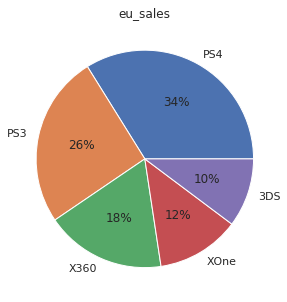

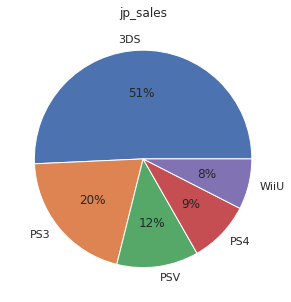

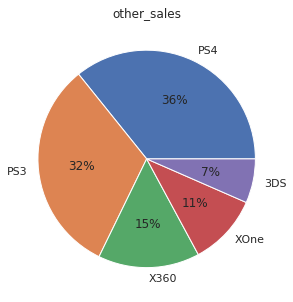

In [562]:
list = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
for i in range(len(list)):    
    platforms = (df_current
     .pivot_table(index='platform', values=list[i], aggfunc={'sum'})
     .sort_values('sum', ascending=False)
     .head())
    plt.pie(platforms, autopct='%1.0f%%', labels=platforms.index)
    plt.title(list[i])
    plt.show()

Лидеры среди платформ по странам:

* Северная Америка: X360 - 28%
* Европа: PS4 - 34%
* Япония: 3DS - 51% (!!)
* Другие страны: PS4 - 36%

#### Самые популярные жанры (топ-5). Поясните разницу.

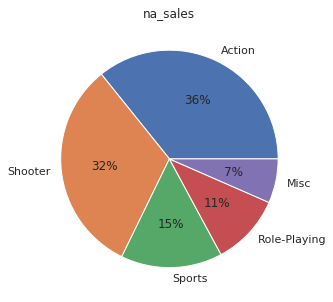

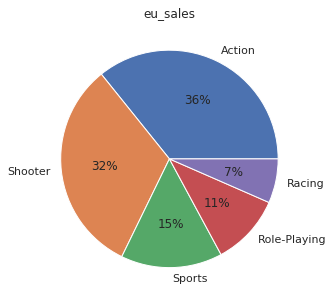

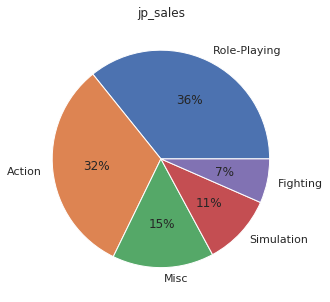

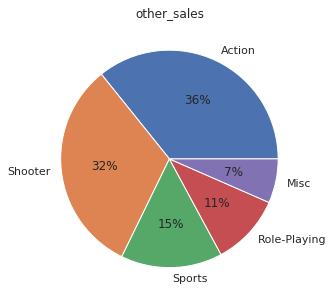

In [563]:
list = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
for i in range(len(list)):    
    genres = (df_current
     .pivot_table(index='genre', values=list[i], aggfunc={'sum'})
     .sort_values('sum', ascending=False)
     .head())
    plt.pie(platforms, autopct='%1.0f%%', labels=genres.index)
    plt.title(list[i])
    plt.show()

В каждой стране кроме Японии жанры Action, Sports и Shooter входят в тройку самых популярных, причём Action и Shoote вместе занимают 2/3 рынка. В Японии жанр Role-playing занимает больше трети рынка, а жанр Shooter не выходит даже в топ-5

Отметим одинаковое процентное распределние жанров по регионам с точностью до процента.

#### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [564]:
esrb_grouped = df_current.pivot_table(index='rating', values=list, aggfunc={'sum'})
esrb_grouped

,eu_sales,jp_sales,na_sales,other_sales
,sum,sum,sum,sum
rating,,,,
E,113.03,28.33,114.37,31.44
E10+,55.37,8.19,75.70,16.23
M,193.96,21.20,231.57,63.38
T,52.96,26.02,66.02,17.94


Создадим столбец *rating_int* показывающий возрастные ограничения в годах. По нему и будем выяснять зависимость.

In [565]:
esrb_grouped['rating_int'] = [6, 10, 17, 13]
esrb_grouped.sort_values('rating_int')

,eu_sales,jp_sales,na_sales,other_sales,rating_int
,sum,sum,sum,sum,
rating,,,,,
E,113.03,28.33,114.37,31.44,6
E10+,55.37,8.19,75.70,16.23,10
T,52.96,26.02,66.02,17.94,13
M,193.96,21.20,231.57,63.38,17


Видим, что основное количество игр приходится на на группу M, т.е. 17+. Однако в Японии ситуация отлична, за исключение группы 10+ распределение игр равномерно.

## Вывод:

Однозначно можем сказать, что рынок Японии сильно отличается от рынка остальных стран.
Самая популярная платформа Японии - DS(51% рынка), самый популярный жанр - Role-Playing более 36%.

Самый популярный жанр в остальных странах - Action.
Жанр занимает 36% рынка.

Для Европы и остальных стран самая популярная платформа PS4 - Более 30%

Для Северной Америки X360 - 28%

Также отметим, что разделяя продажи по рейтингу ERSB обнаружили, что для большинства регионов пик приходится на категорию 17+ или M. 

<div id='id-section5'/>

# Шаг 5. Формулирование и проверка гипотез.

Нулева гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Альтернативная гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC разные

In [566]:
xone = df[df['platform']=='XOne']['user_score'].dropna()
pc = df[(df['platform']=='PC') & (df['year_of_release'] >=2005)]['user_score'].dropna()

Применим тест Левене для проверки гипотезы о равенстве дисперсия. 

Нулевая гипотзеа: дисперсии выборок равны.

Альтернативная гипотеза: диспресии выборок не равны.

In [567]:
alpha = 0.05

if(st.levene(xone, pc).pvalue < alpha):
    print('Нулевая гипотеза отвергнута')
else:
    print('Нулевая гипотеза не может быть отвергнута')

Нулевая гипотеза не может быть отвергнута


Тест Левене показал, что гипотезу о равенстве дисперсий нельзя отвергать. Тогда применим ttest_ind с параметром equal_var=True

In [568]:
result = st.ttest_ind(xone, pc, equal_var=True)

if(result.pvalue < alpha):
    print('Нулевая гипотеза отвергнута')
else:
    print('Нулевая гипотеза не может быть отвергнута')

Нулевая гипотеза отвергнута


Результат говорит о том, что пользовательские рейтинги на Xbox One и PС различаются

#### Рассмотрим следующую гипотезу:

Нулевая гипотеза: Средние пользовательские рейтинги жанров Action и Sports одинаковые

Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action и Sports различны

In [569]:
action = df_current[df_current['genre']=='Action']['user_score'].dropna()
sports = df_current[df_current['genre']=='Sports']['user_score'].dropna()

Применим тест Левене для проверки гипотезы о равенстве дисперсия. 

Нулевая гипотеза: дисперсии выборок равны.

Альтернативная гипотеза: диспресии выборок не равны.

In [570]:
if(st.levene(action, sports).pvalue < alpha):
    print('Нулевая гипотеза отвергнута')
else:
    print('Нулевая гипотеза не может быть отвергнута')

Нулевая гипотеза отвергнута


Результат говорит о том, что дисперсии выборок различны.

In [571]:
result = st.ttest_ind(action, sports, equal_var=False)
alpha = 0.05

if(result.pvalue < alpha):
    print('Нулевая гипотеза отвергнута')
else:
    print('Нулевая гипотеза не может быть отвергнута')

Нулевая гипотеза отвергнута


Результат говорит, о том, средние пользовательские рейтинги жанров Action и Sports различны

## Вывод:

Проверка гипотез показала, что:

* Пользовательские рейтинги на Xbox One и PС различаются

* Средние пользовательские рейтинги жанров Action и Sports различаются

<div id='id-section6'/>

# Шаг 6. Общий вывод

Начиная с 1995 года начинается резкий рост выпуска новых игр для различных платформ.
Далее отметим 2 скачка: в 2002 и 2005 и резкое падение 2009г. до 2012г, далее ситуация более стабильная. На основе графиков, показывающих распределние выпуска игр по годам на самых популярных платформах можем сделать вывод, что за актуальный период можем взять период с 2012 года по 2016. Период появления и исчезновения платформы - 3-4 года.

Видим, что по общим продажам лидируют PS4, PS3 и X360, но к 2016 году продажи PS3 и X360 постепенно падают, т.к. жизненный цикл подходит к концу.
Отметим PS4 и XOne, на 2016 год это свежие и потенциально прибыльные платформы, продажи которых растут, причем PS4 уже лидирует по продажам. 

Сравнивая потенциально прибыльные PS4 и XOne, выпущенные в один год, видим, что на PS4 игры продаются лучше. У платформы PSP очень малый диапазон разброса значений.
Отметим преодоление отметки в 20 млн продаж для PS3 не смотря на то, что с 2012 года ее жизненный цикл подходит к концу.

Делая вывод по всем платформам, можем сказать, что рейтинги пользователей практически никак не влияют на продажи. Зависимость от оценок критиков слабая.

По построенной диаграмме рассеяния видим, что разброс продаж начинается после оценки в 75 баллов от критиков.

Лидеры среди платформ по странам:

* Северная Америка: X360 - 28%
* Европа: PS4 - 34%
* Япония: 3DS - 51% (!!)
* Другие страны: PS4 - 36%

Однозначно можем сказать, что рынок Японии сильно отличается от рынка остальных стран.
Самая популярная платформа Японии - 3DS(51% рынка), самый популярный жанр - Role-Playing более 36%.

Самый популярный жанр в остальных странах - Action.
Жанр занимает 36% рынка.

Для Европы и остальных стран самая популярная платформа PS4 - Более 30%

Для Северной Америки X360 - 28%

Также отметим, что разделяя продажи по рейтингу ERSB обнаружили, что для большинства регионов пик приходится на категорию 17+ или M.

Проверка гипотез показала, что:

* Пользовательские рейтинги на Xbox One и PС различаются

* Средние пользовательские рейтинги жанров Action и Sports различаются

Делая прогноз на 2017 год можем предположить, что будут актуальны платформы PS4 и XOne для большинства регионов т.к. они потенциально более прибыльны. Несмотря на то, что PS3 занимает 1\3 рынка почти везде, эта платформа подходит к концу жизненного цикла.

Для Японского рынка также стоит обратить внимание на PS4, но XOne не пользуется спросом. Продажи на платформе 3DS постепенно падают, но эта платформа занимает более половины рынка.

Лидеры по жанрам Action и Shooter по всему миру кроме Японии, причём рынок всё же менее насыщен жанром Shooter, что показывает большая прибыльность по среднему.

В Японии лидирующую позицию занимает жанр Role-Playing. Action занимает вторую позицию. Жанр Shooter в топ-5 не выходит.

Делая вывод по всему выше сказанному можно сказать, что Японский рынок отличается от рынка остального мира и игра, пользующаяся спросом в мире может не быть таковой в Японии и наоборот.